In [85]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# LCMS Model Setup

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibrationp.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This notebook takes the prepared model calibration featureCollection assets from Module 4, downloads them, sets up LCMS models for Change, Land Cover, and Land Use using scikit-learn, evaluates them, and removes correlated predictor variables. It also finds the best threshold to balance omission and commission for change classes.


### Objective

In this tutorial, you learn how to download data from GEE to use be able to set up models using packages from scikit-learn 

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Bringing in annual exported training data from Module 4
- Downloading these data to a local location
- Identifying highly correlated predictor variables
- Setting up random forest models for Change, Land Cover, and Land Use and evaluating their accuracy and variable importance
- Compute thresholds that balance omission and commission error for change classes

## Before you begin

### If you are working in Workbench: Set your current URL under `workbench_url`
This gives the Map Viewer a url in which to host the viewer we will be generating. 
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/` (See the image below)

![workspace url](img/workspace-url.png)

### Set a folder to use for all exports under `export_path_root` 
* This folder should be an assets folder in an existing GEE project.
* By default, this folder is the same as the pre-baked folder (where outputs have already been created). 
* If you would like to create your own outputs, specify a different path for `export_path_root`, but leave the `pre_baked_path_root` as it was. This way, the pre-baked outputs can be shown at the end, instead of waiting for all exports to finish.
* It will be something like `projects/projectID/assets/someFolder`
* This folder does not have to already exist. If it does not exist, it will be created

In [1]:
workbench_url = 'https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com'
export_path_root  = 'projects/rcr-gee/assets/lcms-training'

print('Done')

Done


# Installation
First, install necessary Python packages. Uncomment the first line to upgrade geeViz if necessary.

Note that for this module, we're also importing many data science packages such as sklearn. 

In [98]:
#Module imports
#!python -m pip install geeViz --upgrade

try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p


try:
    import pandas as pd
except:
    !pip install matplotlib
    import pandas as pd

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

try:
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GroupShuffleSplit
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics 
except:
    !pip install -U scikit-learn
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GroupShuffleSplit
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics 
import numpy as np
import os,json
try:
    import seaborn
except:
    !python -m pip install seaborn
    import seaborn
    
ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1234
print('Done')


SyntaxError: invalid syntax (1585863235.py, line 32)

## Set up your work environment

Create a folder in your export path where you will export the composites. In addition, create a blank image collection where your composites will live.

Currently, when running within Colab or Workbench, geeView uses a different project to authenticate through, so you may need to make your asset public to view from within Colab.

In [94]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_timeSync_folder = f'{export_path_root}/lcms-training_module-4_timeSync'

# This is the pre-made TimeSync data
# Creating this dataset is not covered in this set of notebooks
timeSync_featureCollection = 'projects/rcr-gee/assets/training-materials/18_PRVI_AllPlots_TimeSync_Annualized_Table_secLC_wStrata'


# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_timeSync_folder,writers = [],all_users_can_read = True,readers = [])

print('Done')

Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync
Done


In [95]:
# set up map
Map.clearMap()

# reset port if necessary
Map.port = 1235
Map.proxy_url = workbench_url

print('Done')

Done


**Download Data from GEE**

* LCMS does much of its model setup and analysis locally
* We will first need to bring in the training data we exported in Module 4, merge it into a single featureCollection, crosswalk some fields to numerica values, and download the data

In [36]:

# Bring in raw TS data
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
timeSync_fields = timeSyncData.first().toDictionary().keys().getInfo()

# Now lets bring in all training data and prep it for modeling
assets = ee.data.listAssets({'parent': export_timeSync_folder})['assets']

# You may need to change the permissions for viewing model outputs in geeViz
# Uncomment this if needed
#for asset in assets:aml.updateACL(asset['name'],writers = [],all_users_can_read = True,readers = [])

# Read in each year of extracted TimeSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2020-6").first().toDictionary().getInfo()
                                             
print('LCMS class code, names, and colors:',lcms_viz_dict)


# Get the field names for prediction
# Find any field that was not in the original TimeSync data and assume that is a predictor variable
all_fields = training_data.first().toDictionary().keys().getInfo()
predictor_field_names = [field for field in all_fields if field not in timeSync_fields]

# Take out the date predictor
predictor_field_names = [nm for nm in predictor_field_names if nm != 'year']

# Filter out any non null values (any training plot with missing predictor data will cause the model to fail entirely)
training_data = training_data.filter(ee.Filter.notNull(predictor_field_names))

print('Filtered number of training samples:',training_data.size().getInfo())


LCMS class code, names, and colors: {'Change_class_names': ['Stable', 'Slow Loss', 'Fast Loss', 'Gain', 'Non-Processing Area Mask'], 'Change_class_palette': ['3d4551', 'f39268', 'd54309', '00a398', '1b1716'], 'Change_class_values': [1, 2, 3, 4, 5], 'Land_Cover_class_names': ['Trees', 'Tall Shrubs & Trees Mix (SEAK Only)', 'Shrubs & Trees Mix', 'Grass/Forb/Herb & Trees Mix', 'Barren & Trees Mix', 'Tall Shrubs (SEAK Only)', 'Shrubs', 'Grass/Forb/Herb & Shrubs Mix', 'Barren & Shrubs Mix', 'Grass/Forb/Herb', 'Barren & Grass/Forb/Herb Mix', 'Barren or Impervious', 'Snow or Ice', 'Water', 'Non-Processing Area Mask'], 'Land_Cover_class_palette': ['005e00', '008000', '00cc00', 'b3ff1a', '99ff99', 'b30088', 'e68a00', 'ffad33', 'ffe0b3', 'ffff00', 'aa7700', 'd3bf9b', 'ffffff', '4780f3', '1b1716'], 'Land_Cover_class_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'Land_Use_class_names': ['Agriculture', 'Developed', 'Forest', 'Non-Forest Wetland', 'Other', 'Rangeland or Pasture', 'No

* Since all modeled variables must be numeric, we will need to crosswalk the named values to numbers
* Note that while land cover and land use have a number for each name, change crosswalks into 4 categories

Crosswalking: Land_Cover
Crosswalking: Land_Use
Crosswalking: Change
Converted codes first plot: {'CP': 'Stable', 'CP_Code': 1, 'DOM_LU': 'Developed', 'DOM_LU_Code': 2, 'DOM_SEC_LC': 'GRASS', 'DOM_SEC_LC_Code': 10}


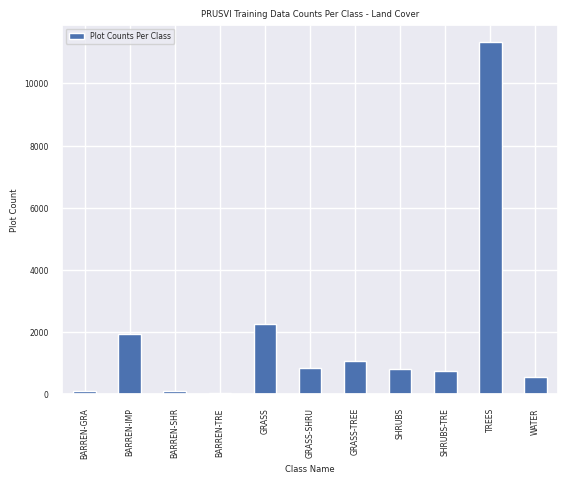

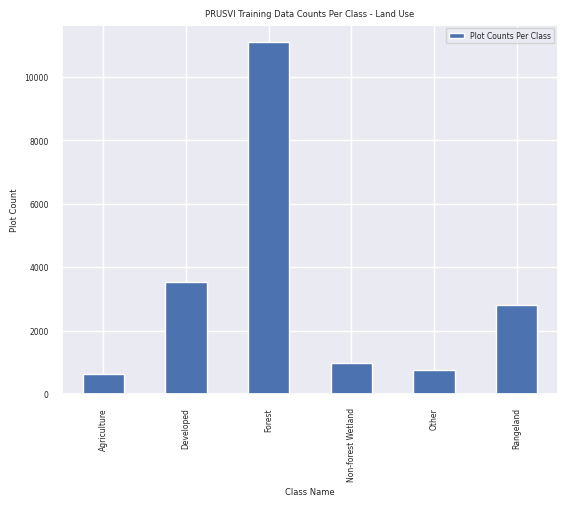

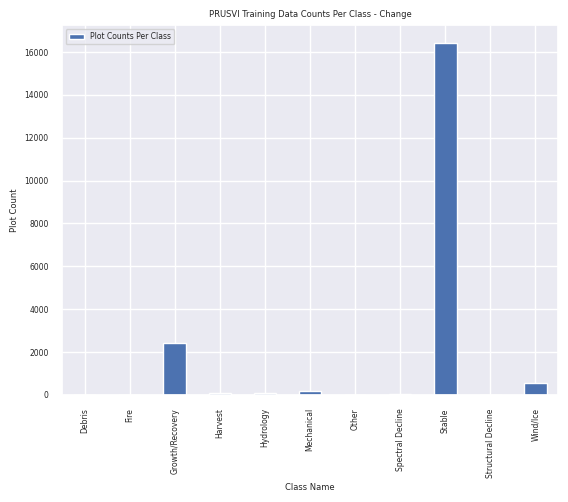

In [37]:
# Now, we'll crosswalk the training fields to numeric codes
# The TimeSync fields are a string by default
# They must be a number for modeling
# Set up lookup dictionaries to convert the names to numeric codes
land_cover_name_code_dict = ee.Dictionary({'TREES':1,
                             'TSHRUBS-TRE':2,
                             'SHRUBS-TRE':3,
                             'GRASS-TREE':4,
                             'BARREN-TRE':5,
                             'TSHRUBS':6,
                             'SHRUBS':7,
                             'GRASS-SHRU':8,
                             'BARREN-SHR':9,
                             'GRASS':10,
                             'BARREN-GRA':11,
                             'BARREN-IMP':12,
                             'SNOW-ICE':13,
                             'WATER':14
                            })
land_use_name_code_dict = ee.Dictionary({'Agriculture':1,
                           'Developed':2,
                           'Forest':3,
                           'Non-forest Wetland':4,
                           'Other':5,
                           'Rangeland':6
                          })

change_code_dict = ee.Dictionary({'Debris': 3, 
                                  'Fire': 3, 
                                  'Growth/Recovery': 4, 
                                  'Harvest': 3, 'Hydrology': 3, 
                                  'Mechanical': 3, 
                                  'Other': 3, 
                                  'Spectral Decline': 2, 
                                  'Stable': 1, 
                                  'Structural Decline': 2, 
                                  'Wind/Ice': 3})

reference_field_dict = {'Land_Cover':{'field':'DOM_SEC_LC','name_code_dict':land_cover_name_code_dict},
                        'Land_Use':{'field':'DOM_LU','name_code_dict':land_use_name_code_dict},
                        'Change':{'field':'CP','name_code_dict':change_code_dict,
                                  'fields':['Slow Loss', 'Fast Loss', 'Gain']}
                       }
# Make a function that will get the code for a given name and set it
# We could also use the remap function to accomplish this
def set_class_code(plot,product):
    name_fieldName = reference_field_dict[product]['field']
    code_fieldName = ee.String(name_fieldName).cat('_Code')
    name = ee.String(plot.get(name_fieldName))
    code = reference_field_dict[product]['name_code_dict'].get(name)
    plot = plot.set(code_fieldName,code)
    return plot
                    
                    
# Crosswalk each product and visualize the frequency of each class
for product in list(reference_field_dict.keys()):
    print('Crosswalking:',product)
    product_title = product.replace('_',' ')
    
    # Crosswalk class names to numbers
    training_data = training_data.map(lambda f:set_class_code(f,product))
    
    # Get the counts
    counts = training_data.aggregate_histogram(reference_field_dict[product]['field']).getInfo()
    
    # Plot the counts by class
    counts_df = g2p.pandas.DataFrame(counts.values(),columns = ['Plot Counts Per Class'],index =counts.keys() )
    counts_df.plot.bar(xlabel='Class Name',ylabel='Plot Count', title = f'PRUSVI Training Data Counts Per Class - {product_title}')
    
# Take a look at the resulting cross-walked table for a plot
print('Converted codes first plot:',ee.Feature(training_data.first()).select(['CP','DOM_SEC_LC','DOM_LU','.*_Code']).toDictionary().getInfo())


* Notice the samples are imbalanced
* We will have to keep this in mind when evaluating our models

* Next, we will download these data to a local location for use in Pandas/sklearn/etc..

In [38]:
# Now will download the training table to a local location

local_model_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_model_data_folder,'timeSync_training_table.csv')


if not os.path.exists(local_model_data_folder):os.makedirs(local_model_data_folder)

# Download the training data from a featureCollection to a local CSV
# This function will automatically break the featureCollection into 5000 feature featureCollections
# if it is larger than the 5000 feature limit set by GEE
g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False)

# Once the table is store locally, read it in
training_df = pd.read_csv(local_training_csv)

training_df.describe()

/tmp/lcms-training/local_modeling/timeSync_training_table.csv  already exists


,BARREN,BARREN-GRA,BARREN-IMP,BARREN-SHR,BARREN-TRE,BARREN-TS,CHANGE_DUR,CP_Code,DOM_LU_Code,DOM_SEC_LC_Code,...,swir2_LT_dur,swir2_LT_fitted,swir2_LT_mag,swir2_LT_slope,wetness_LT_diff,wetness_LT_dur,wetness_LT_fitted,wetness_LT_mag,wetness_LT_slope,year
count,19778.0,19778.000000,19778.000000,19778.000000,19778.000000,19778.0,19778.000000,19778.00000,19778.000000,19778.000000,...,19778.000000,19778.000000,19778.000000,19778.000000,19778.000000,19778.000000,19778.000000,19778.000000,19778.000000,19778.000000
mean,0.0,0.005359,0.098089,0.004955,0.002174,0.0,14.326727,1.45945,3.307918,4.352715,...,26.315502,0.079638,0.005556,0.000505,-0.013640,29.233997,-0.073240,-0.020892,-0.000419,2011.236828
std,0.0,0.073014,0.297442,0.070219,0.046578,0.0,6.767959,1.03579,1.297696,4.435463,...,11.269760,0.039771,0.033831,0.005742,0.029335,10.805686,0.044393,0.042005,0.005689,6.040327
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.00000,1.000000,1.000000,...,1.000000,0.006793,-0.210283,-0.070094,-0.322420,1.000000,-0.440766,-0.483630,-0.053737,2000.517822
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,9.000000,1.00000,3.000000,1.000000,...,17.000000,0.053389,-0.011057,-0.000472,-0.025358,21.000000,-0.096936,-0.039508,-0.001391,2006.169922
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,17.000000,1.00000,3.000000,1.000000,...,28.000000,0.069915,0.006628,0.000233,-0.012718,37.000000,-0.066459,-0.021964,-0.000678,2011.295898
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,21.000000,1.00000,3.000000,9.000000,...,38.000000,0.095523,0.021770,0.000902,0.000000,38.000000,-0.045341,0.000000,0.000000,2016.476685
max,0.0,1.000000,1.000000,1.000000,1.000000,0.0,21.000000,4.00000,6.000000,14.000000,...,38.000000,0.373654,0.300531,0.204653,0.381094,38.000000,0.072465,0.381094,0.226203,2021.411011


**Remove Correlated Variables**

* Often variables are correlated to one another. We will look for these variables, and eliminate one of each correlated pair of variables
* First, we will visualize the correlation between the first 50 variables 
    * Visualizing all variables at once is difficult on a normal-sized screen

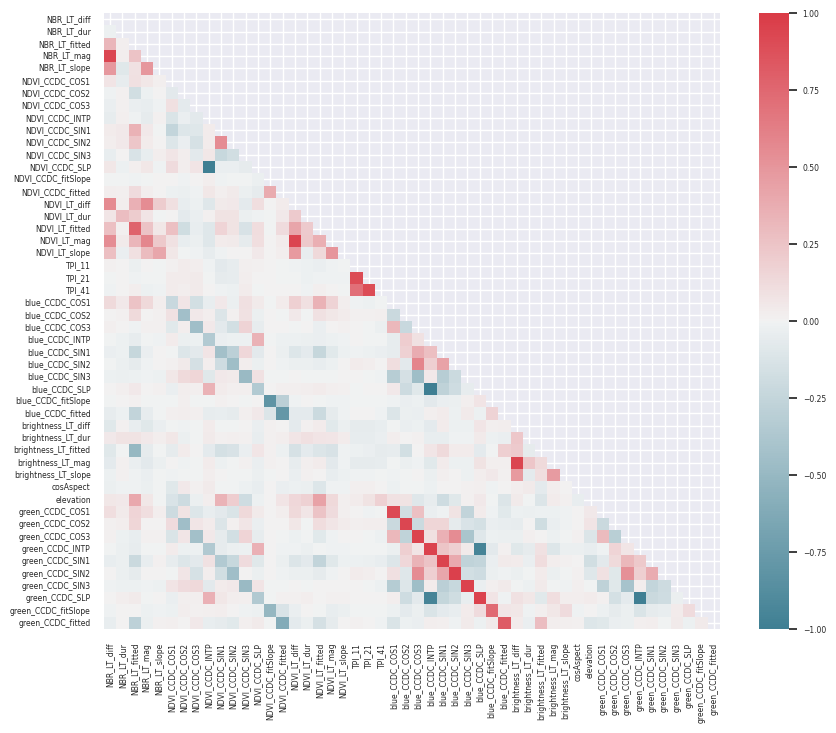

In [39]:
# Once the data are local, we can use the many packages available in Python and even R for data science
# The first step in feature selection (predictor variable selection) 
# LCMS performs is to eliminate extremely correlated predictor variables
# First, we will visualize the correlation of each pair of variables for the first 50 variables
# You can look at all variables, but it is difficult to read the variable name
# The take-home is there are some highly correlated variables that are likely not providing the model much additional information

# Get the correlation matrix for the first 50 variables
corr = training_df[predictor_field_names[:50]].corr()

# Mask out the upper right triangle and the 1:1 diagonal which always has a corr of 1
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))

# Plot the matrix
seaborn.set(font_scale=0.5)
f, ax = plt.subplots(figsize=(10, 8))

corrPlot = seaborn.heatmap(corr,
    cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)


* In order to remove correlated variables, we will find pairs with a $R^2 > 0.95$ and take the variable with the lowest average $R^2$ in the pair


In [40]:
# This is the function LCMS uses
# There are many ways of doing this, but this is a simple way that generally gives a good result
def lcms_corr_drop(x,cut = 0.95):
    # Get independent variables from training data table    
    indNames = x.columns
   
    # Find initial correlation of each feature to the others
    corr_matrix = x.corr().pow(2)
    
    # Calculate average correlation score of each variable
    corr_score = [corr_matrix[variable].mean() for variable in indNames]
    corr_score = zip(corr_score,indNames)
    sorted_scores = sorted(corr_score, reverse=True)
    sorted_indNames = [element for _, element in sorted_scores]

    # Redo the correlation matrix with the new order of variable names
    x = x[sorted_indNames]
    corr_matrix = x.corr().abs()
    
    # Select lower triangle of correlation matrix
    upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)) # numpy error, np.bool is deprecated, changed to bool
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > cut)]
    return to_drop

print('Done')

Done


* We will now apply the function and save what variables are available, and which ones are not correlated

In [41]:
# Find correlated variables to drop and remove them from the predictor field name list
lcms_to_drop = lcms_corr_drop(training_df[predictor_field_names],cut = 0.95)
print('Correlated variables:',lcms_to_drop)

predictor_field_names_no_corr = [var for var in predictor_field_names if var not in lcms_to_drop]

# Save predictor variables for use in next notebook
all_predictors_csv = os.path.join(local_model_data_folder,'all_predictor_field_names.csv')
o = open(all_predictors_csv,'w')
o.write(','.join(predictor_field_names))
o.close()

no_corr_predictors_csv = os.path.join(local_model_data_folder,'no_corr_predictor_field_names.csv')
o = open(no_corr_predictors_csv,'w')
o.write(','.join(predictor_field_names_no_corr))
o.close()

print('Done')

Correlated variables: ['red_CCDC_INTP', 'green_CCDC_INTP', 'green_CCDC_SLP', 'blue_CCDC_SLP', 'swir2_CCDC_SLP', 'swir1_CCDC_SLP', 'green_CCDC_COS3', 'blue_CCDC_SIN1', 'NDVI_CCDC_SLP', 'blue_CCDC_SIN2', 'green_CCDC_SIN3', 'nir_CCDC_SLP', 'swir2_CCDC_fitted', 'swir1_CCDC_fitSlope']
Done


**Fit Random Forest Model**

* Now we will fit a random forest model for each product and learn about how well it performs

In [99]:

# Now we will fit RF models and evaluate them using several methods
# This will help us understand the error structure within the model

# Specify the number of trees and a random seed
# Ideally the number of trees is around 150-250 or so, but it will take a long
# time to run the analysis when it's at 150 or so. 50 is generally enough to get a sense of model accuraccy
nTrees = 50
seed = 999

def fit_rf(product_name,predictor_fields,title_prefix='',var_importance_n = 50):
    product_title = product_name.replace('_',' ')
    
    # Pull out the dependent (y) and independent predictors (X)
    X = training_df[predictor_fields]
    y = training_df[reference_field_dict[product_name]['field']+'_Code']
    
    # Split them into a test and train set for further model evaluation
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Ensure all plots are grouped into either test or split so temporally auto-correlated 
    # plots do not get into the training set and inflate accuracy
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8)
    for i, (train_index, test_index) in enumerate(gss.split(X, y, groups)):
        train_index = train_index
        test_index = test_index

    X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]

    # Set up a random forest model
    rf = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
    
    # First, fit it using all training data
    rf.fit(X,y)
    
    # Get the out-of-bag accuracy 
    # This is generally a good indication of model accuracy
    oob_acc = rf.oob_score_
    print(f'{title_prefix} {product_title} out-of-bag accuracy:',"%.4f" % oob_acc)
    
    # Now let's look at the variable importance
    feature_importances = pd.Series(rf.feature_importances_, index=predictor_fields).sort_values(ascending=True)
    feature_importances.iloc[-var_importance_n:].plot.barh(fontsize=5,title=f'{title_prefix} {product_title} Variable Importance')
    plt.show()
 
    # Now, fit the model using the 80% training subset
    rf.fit(X_train,y_train)
    
    # And then apply it to the 20% test subset
    y_pred = rf.predict(X_test)

    # Find the class names
    class_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    
    # Remove the missing classes in PRUSVI
    if product_name == 'Land_Cover':
        del class_names[1]
        del class_names[4]
        del class_names[-2]
    
    # Get various accuracy metrics
    overall_acc = metrics.accuracy_score(y_test, y_pred)
    balanced_acc = metrics.balanced_accuracy_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)
    
    # Print info about the model
    print(f'{title_prefix} {product_title} report:')
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    print(f'{title_prefix} {product_title} Overall Accuracy:',"%.4f" % overall_acc)
    print(f'{title_prefix} {product_title} Balanced Accuracy:',"%.4f" % balanced_acc)
    print(f'{title_prefix} {product_title} Kappa:',"%.4f" % kappa)
    
    predictors_by_importance = feature_importances.index.tolist()
    predictors_by_importance.reverse()
    return oob_acc,overall_acc,balanced_acc,kappa,predictors_by_importance
print('Done')

Done


All Predictors Change out-of-bag accuracy: 0.9031


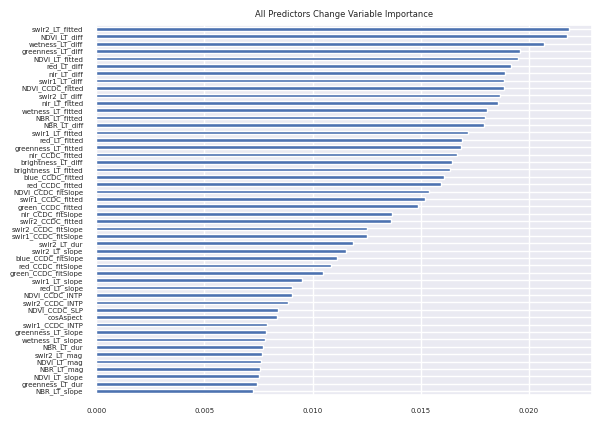

All Predictors Change report:
              precision    recall  f1-score   support

      Stable     0.8422    0.9958    0.9126      3323
   Slow Loss     0.0000    0.0000    0.0000        13
   Fast Loss     0.6923    0.0486    0.0909       185
        Gain     0.4783    0.0248    0.0471       444

    accuracy                         0.8396      3965
   macro avg     0.5032    0.2673    0.2626      3965
weighted avg     0.7917    0.8396    0.7743      3965

All Predictors Change Overall Accuracy: 0.8396
All Predictors Change Balanced Accuracy: 0.2673
All Predictors Change Kappa: 0.0493


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non-correlated Predictors Change out-of-bag accuracy: 0.9042


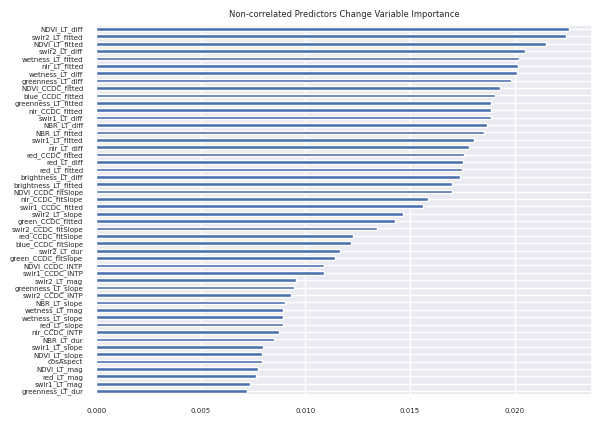

Non-correlated Predictors Change report:
              precision    recall  f1-score   support

      Stable     0.8661    0.9956    0.9264      3443
   Slow Loss     0.0000    0.0000    0.0000         5
   Fast Loss     0.8333    0.0613    0.1143       163
        Gain     0.5333    0.0411    0.0764       389

    accuracy                         0.8635      4000
   macro avg     0.5582    0.2745    0.2793      4000
weighted avg     0.8313    0.8635    0.8094      4000

Non-correlated Predictors Change Overall Accuracy: 0.8635
Non-correlated Predictors Change Balanced Accuracy: 0.2745
Non-correlated Predictors Change Kappa: 0.0742


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top 30 Var Imp Change out-of-bag accuracy: 0.8927


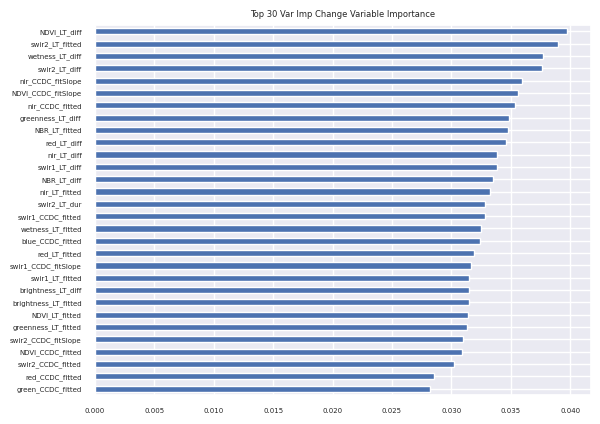

Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.8234    0.9938    0.9006      3247
   Slow Loss     0.0000    0.0000    0.0000        18
   Fast Loss     0.7500    0.0710    0.1297       169
        Gain     0.4286    0.0227    0.0431       529

    accuracy                         0.8203      3963
   macro avg     0.5005    0.2719    0.2684      3963
weighted avg     0.7638    0.8203    0.7492      3963

Top 30 Var Imp Change Overall Accuracy: 0.8203
Top 30 Var Imp Change Balanced Accuracy: 0.2719
Top 30 Var Imp Change Kappa: 0.0477


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non Corr Top 30 Var Imp Change out-of-bag accuracy: 0.8920


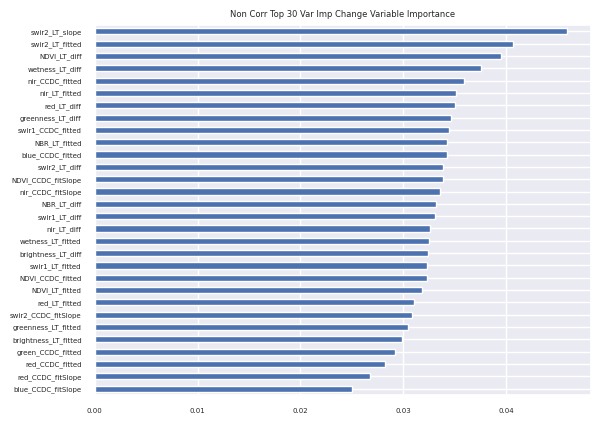

Non Corr Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.8332    0.9933    0.9062      3288
   Slow Loss     0.0000    0.0000    0.0000         3
   Fast Loss     0.7826    0.0984    0.1748       183
        Gain     0.4242    0.0279    0.0523       502

    accuracy                         0.8295      3976
   macro avg     0.5100    0.2799    0.2833      3976
weighted avg     0.7786    0.8295    0.7641      3976

Non Corr Top 30 Var Imp Change Overall Accuracy: 0.8295
Non Corr Top 30 Var Imp Change Balanced Accuracy: 0.2799
Non Corr Top 30 Var Imp Change Kappa: 0.0701


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All Predictors Land Cover out-of-bag accuracy: 0.9744


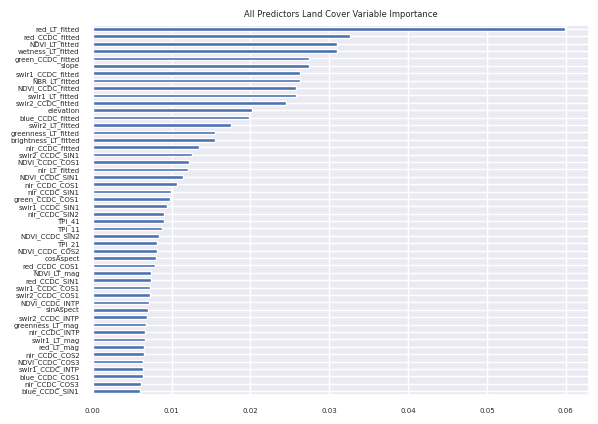

All Predictors Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.7838    0.9808    0.8713      2292
          Shrubs & Trees Mix     0.0000    0.0000    0.0000       129
 Grass/Forb/Herb & Trees Mix     0.2069    0.0302    0.0526       199
          Barren & Trees Mix     0.0000    0.0000    0.0000        10
                      Shrubs     0.4286    0.0536    0.0952       168
Grass/Forb/Herb & Shrubs Mix     0.0385    0.0070    0.0119       142
         Barren & Shrubs Mix     0.0000    0.0000    0.0000        31
             Grass/Forb/Herb     0.6396    0.5788    0.6077       463
Barren & Grass/Forb/Herb Mix     0.0000    0.0000    0.0000        34
        Barren or Impervious     0.7045    0.9815    0.8203       379
                       Water     0.9800    0.5104    0.6712        96

                    accuracy                         0.7489      3943
                   macro avg     0.3438    0.2857    0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non-correlated Predictors Land Cover out-of-bag accuracy: 0.9750


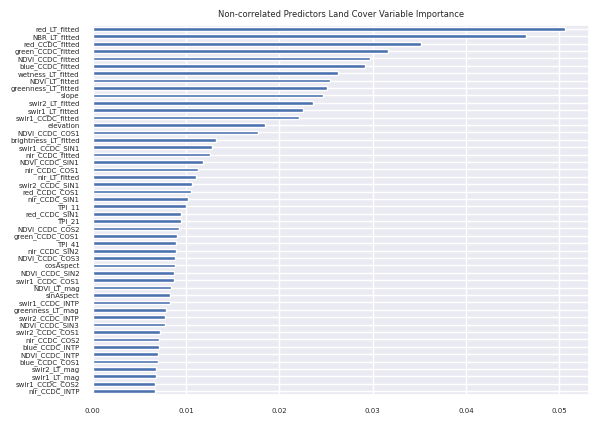

In [ ]:
# Now evaluate models for each LCMS product with various sets of predictor variables
# and create a summary table
product_names = ['Change','Land_Cover','Land_Use']

acc_table = []
for product_name in product_names:
    
    # First fit a model using all predictors
    all_model_info = list(fit_rf(product_name,predictor_field_names,'All Predictors'))
    all_model_info.insert(0,'All Predictors')
    all_model_info.insert(0,product_name)
    acc_table.append(all_model_info)
    
    # Then fit a model using the variables with < 0.95 r-squared
    non_corr_model_info = list(fit_rf(product_name,predictor_field_names_no_corr,'Non-correlated Predictors'))
    non_corr_model_info.insert(0,'Non-correlated Predictors')
    non_corr_model_info.insert(0,product_name)
    acc_table.append(non_corr_model_info)
    
    # Next take only the top 30 predictors regardless of co-variance 
    all_top30_model_info = list(fit_rf(product_name,all_model_info[-1][:30],'Top 30 Var Imp'))
    all_top30_model_info.insert(0,'All Predictors Top 30')
    all_top30_model_info.insert(0,product_name)
    acc_table.append(all_top30_model_info)
    
    # Then take the top 30 with < 0.95 r-squared
    non_corr_top30_model_info = list(fit_rf(product_name,non_corr_model_info[-1][:30],'Non Corr Top 30 Var Imp'))
    non_corr_top30_model_info.insert(0,'Non-correlated Predictors Top 30')
    non_corr_top30_model_info.insert(0,product_name)
    acc_table.append(non_corr_top30_model_info)

print('Done')

* Now, let's compile all these results into a single table to make some sense of the possibilities

In [44]:
model_options_df = pd.DataFrame(acc_table,columns = ['Product Name','Model Name','OOB Acc','Overall Acc','Balanced Acc','Kappa','Var Imp'])
display(model_options_df)

# Save table for use in notebook 5.2
model_options_csv_filename = os.path.join(local_model_data_folder,'LCMS_model_options_table.csv')
model_options_df.to_csv(model_options_csv_filename,index=False)
    
print('Done')

,Product Name,Model Name,OOB Acc,Overall Acc,Balanced Acc,Kappa,Var Imp
0,Change,All Predictors,0.903074,0.889535,0.539383,0.579055,"[swir2_LT_fitted, NDVI_LT_diff, wetness_LT_dif..."
1,Change,Non-correlated Predictors,0.904237,0.899141,0.580823,0.616180,"[NDVI_LT_diff, swir2_LT_fitted, NDVI_LT_fitted..."
2,Change,All Predictors Top 30,0.892659,0.884732,0.462668,0.512928,"[NDVI_LT_diff, swir2_LT_fitted, wetness_LT_dif..."
3,Change,Non-correlated Predictors Top 30,0.892001,0.893327,0.523563,0.518106,"[swir2_LT_slope, swir2_LT_fitted, NDVI_LT_diff..."
4,Land_Cover,All Predictors,0.974365,0.973205,0.875548,0.957708,"[red_LT_fitted, red_CCDC_fitted, NDVI_LT_fitte..."
5,Land_Cover,Non-correlated Predictors,0.974972,0.969414,0.877008,0.951876,"[red_LT_fitted, NBR_LT_fitted, red_CCDC_fitted..."
6,Land_Cover,All Predictors Top 30,0.973405,0.971183,0.908831,0.955286,"[NBR_LT_fitted, red_LT_fitted, red_CCDC_fitted..."
7,Land_Cover,Non-correlated Predictors Top 30,0.973405,0.970172,0.888568,0.952752,"[red_LT_fitted, green_CCDC_fitted, slope, red_..."
8,Land_Use,All Predictors,0.994084,0.995450,0.990888,0.992641,"[red_LT_fitted, NDVI_LT_fitted, swir2_CCDC_fit..."
9,Land_Use,Non-correlated Predictors,0.994489,0.993175,0.988848,0.988846,"[red_LT_fitted, NBR_LT_fitted, red_CCDC_fitted..."


Done


* Take a look at the files we've created 

In [45]:
os.listdir(local_model_data_folder)

['no_corr_predictor_field_names.csv',
 'all_predictor_field_names.csv',
 'timeSync_training_table.csv',
 'LCMS_model_options_table.csv',
 'LCMS_change_thresholds.csv']

* We will now use the results from the previous step inside the GEE random forest modeling environment
* You will notice some similarities and differences

Getting model info for All Predictors Change
All Predictors Change OOB Accuracy: 0.9221094754894955


,Stable,Slow Loss,Fast Loss,Gain,Producers Accuracy (1 - omission error)
Stable,17542,0,0,2,99
Slow Loss,1,31,0,0,96
Fast Loss,57,0,852,5,93
Gain,20,0,0,2481,99
Consumers Accuracy (1 - commission error),99,100,100,99,99


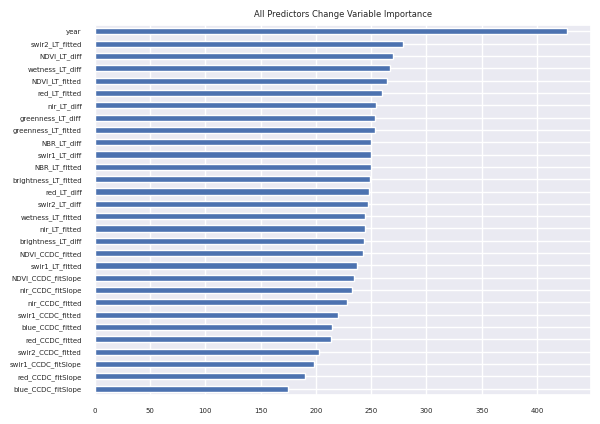

AttributeError: 'FeatureCollection' object has no attribute 'confusionMatrix'

In [14]:

# Not let's train similar models inside GEE to see the similarities and differences

# Set some parameters
top_n_variables = 30 # Take this number of variables into the final model
nTrees = 50

# Function to take GEE variable importance and make a pyplot barchart
def var_importance_plot(importance_dict,title = 'Variable Importance', n_variables = 30,descending = True):
    feature_importances = pd.Series(importance_dict.values(), index=importance_dict.keys())\
                            .sort_values(ascending=descending)\
                            .iloc[-n_variables:]
    feature_importances.plot.barh(title=title,fontsize=5);
    plt.show()
# Function to take GEE confusionMatrix object and make a Pandas dataframe from it
def formatConfusionMatrix(confusionMatrix,code_names):
    # Only make one call to GEE for the confusion matrix info
    cm_info = ee.Dictionary({
        'accuracy':confusionMatrix.accuracy(),
        'consumersAccuracy':confusionMatrix.consumersAccuracy(),
        'producersAccuracy':confusionMatrix.producersAccuracy(),
        'confusionMatrix':confusionMatrix
    }).getInfo()
    
    # Pull the overall accuracy (this is not from the out-of-bag samples, os is higher than the OOB accuracy
    overall_accuracy = int(cm_info['accuracy']*100)
    
    # Get the consumers accuracy and get rid of the 0 value (1 - commission error)
    consumers_accuracy = [int(i*100) for i in cm_info['consumersAccuracy'][0][1:]]
    consumers_accuracy.append(overall_accuracy)
    
    # Get the producers accuracy and get rid of the 0 value (1 - omission error)
    producers_accuracy = [int(i[0]*100) for i in cm_info['producersAccuracy'][1:]]
    
    # Pull in the confusion matrix (this uses all samples, so it is far more accurate than reality)
    confusionMatrix = cm_info['confusionMatrix']
    
    # Get rid of 0 value row and column (0 is not used for any LCMS output value)
    confusionMatrix = [row[1:] for row in confusionMatrix[1:]]
    
    # Append the producers and consumers accuracy
    confusionMatrix2 = []
    for i,row in enumerate(confusionMatrix):
        row.append(producers_accuracy[i])
        confusionMatrix2.append(row)
    confusionMatrix2.append(consumers_accuracy)
    
    # Give meaningful row and column names
    row_names = code_names.copy()
    col_names = code_names.copy()
    row_names.append('Consumers Accuracy (1 - commission error)')
    col_names.append('Producers Accuracy (1 - omission error)')
    
    # Show the confusion matrix
    display(pd.DataFrame(confusionMatrix2 ,index = row_names,columns = col_names))
    
# Function to get info from a GEE random forest model
def getModelInfo(model, code_names,title = ''):
    print('Getting model info for',title)
    
    
    importance = model.explain().get('importance').getInfo()
    OOB_accuraccy = 1- model.explain().get('outOfBagErrorEstimate').getInfo()
    
    print(f'{title} OOB Accuracy: {OOB_accuraccy}')
    confusionMatrix = model.confusionMatrix()
    formatConfusionMatrix(confusionMatrix,code_names)
    
    # Get the variable importance plot
    return var_importance_plot(importance,title + ' Variable Importance')
    
rf_models = {}
def fit_rf(product_name):
    product_title = product_name.replace('_',' ')
    # Set up RF model 
    rf = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)

    # Fit the RF model using all predictors
    rf = rf.train(training_data, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    rf_models[product_name] = rf
    # Get model info
    code_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    importance = getModelInfo(rf, code_names,f'All Predictors {product_title}')
    
    
    # Set up a holdout to evaluate model with
    training = training_data.filter("random < 0.8")
    holdout = training_data.filter("random >= 0.8")
    rf2 = rf.train(training, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    validation = holdout.classify(rf2,'predicted')
    
    confusionMatrix = validation.confusionMatrix(reference_field_dict[product_name]['field']+'_Code', "predicted")
    formatConfusionMatrix(confusionMatrix,code_names)
    # print(errorMatrix.getInfo())

    
    # predicted = predictor_stack.classify(rf,product_name).set(lcms_viz_dict)

    # Map.addLayer(predicted,{'autoViz':True},f'All Predictors {product_title} {apply_year}')
    
# Run GEE RF models 
training_data = training_data.randomColumn(seed=seed)
for product in ['Land_Cover','Land_Use','Change'][-1:]:
    fit_rf(product)
# print(training_data.size().getInfo())
# Notice the out-of-bag accuracy is roughly the same as in scikit-learn random forest

# # importance = var_importance_plot(rf_lc_info['importance'],'Land Cover All Variables')
# rf_lc = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
# lc_predictor_field_names =  list(importance.keys())
# rf_lc = rf_lc.train(training_data, reference_field_dict['Land_Cover']['field']+'_Code',lc_predictor_field_names)#['NBR_LT_fitted'])
# # importance = rf_lc.explain().get('importance').getInfo()
# getModelInfo(rf_lc, lcms_viz_dict['Land_Cover_class_names'][:-1],f'Top {top_n_variables} Variables Land Cover')
# # var_importance_plot(importance,f'Land Cover Top {top_n_variables}')


# lc_predicted = predictor_stack.classify(rf_lc,'Land_Cover').set(lcms_viz_dict)
# # # print(lc_predicted.bandNames().getInfo())
# Map.addLayer(lc_predicted,{'autoViz':True},f'Land Cover Top {top_n_variables}')
# Map.turnOnInspector()
# Map.view()

# Notice that there is quite a bit omission error in fast loss even for the training samples. 
# This means the omission error is likely much higher in reality

**Change Threshold Computing**

* Change is generally a rare class
* Our training data have far more stable plots than change plots
* As a result, most of the time, our models are not very confident of change
* We do not use the class the model was most confident of for change classification
* Instead, we take any of the 3 change classes that are above a threshold that balances omission and commission error and then take the most confident classs (should more than one be above their respective thresholds)
* The next blocks compute the thresholds that balance omission and commission

In [78]:

nTrees=150

product_name = 'Change'


# First set up a the predictor and reference field names
model_options_df = model_options_df[model_options_df['Model Name'] == 'Non-correlated Predictors Top 30']

# Pull the predictor variables from the prior exercise
predictor_variable_names = model_options_df[model_options_df['Product Name'] == product_name]['Var Imp'].values[0]

code_field_name = reference_field_dict[product_name]['field']+'_Code'

# Split the training data as we did before into dependent (y) and independent (X) variables
X = training_df[predictor_variable_names]
y = training_df[code_field_name]
groups = training_df['PLOTID']
# Split them into a test and train set for further model evaluation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Ensure all plots are grouped into either test or split so temporally auto-correlated 
# plots do not get into the training set and inflate accuracy
gss = GroupShuffleSplit(n_splits=1, train_size=0.8)
for i, (train_index, test_index) in enumerate(gss.split(X, y, groups)):
    train_index = train_index
    test_index = test_index

X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]

# Set up a random forest model
print('Fitting models for thresholding')
rf_all = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
rf_holdout = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)

# Fit using all training as well as the holdout
rf_all = rf_all.fit(X,y)
rf_holdout = rf_holdout.fit(X_train,y_train)

# Apply the model and get the proportion of votes for each class
rf_all_probs = rf_all.predict_proba(X)
rf_holdout_probs = rf_holdout.predict_proba(X_test)


print('Done')

Fitting models for thresholding
Done


Stable 1


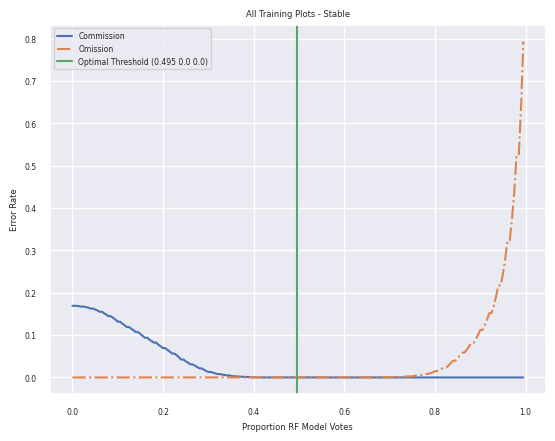

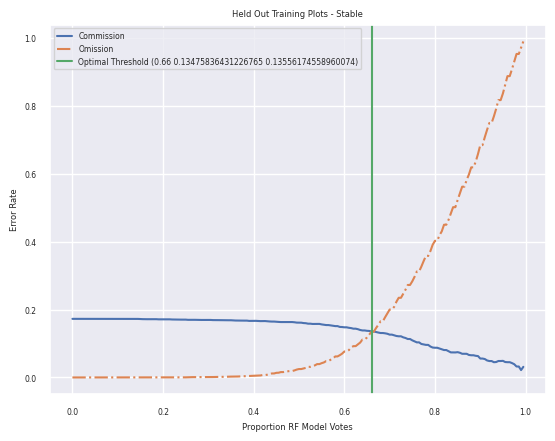

Slow Loss 2


/var/tmp/ipykernel_32623/628807445.py:23: RuntimeWarning: invalid value encountered in long_scalars
  commission.append(sum(fp)/sum(pred_positive))


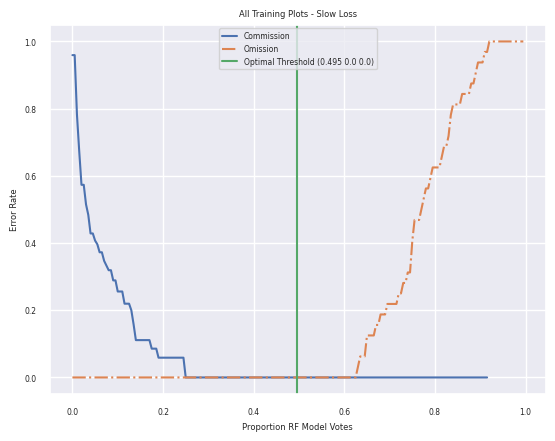

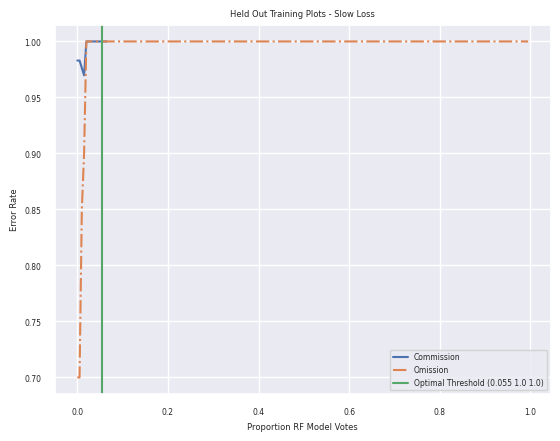

Fast Loss 3


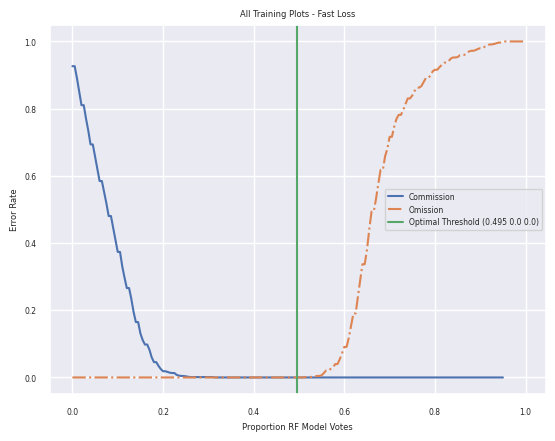

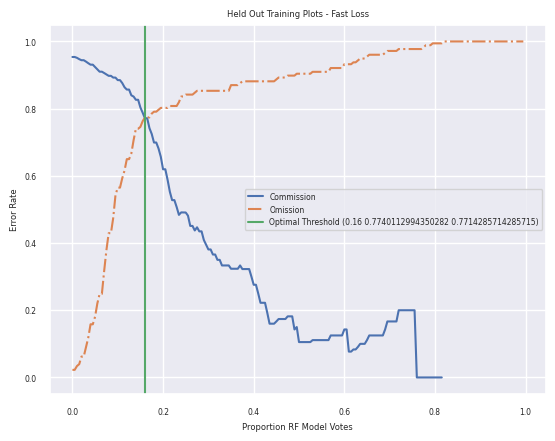

Gain 4


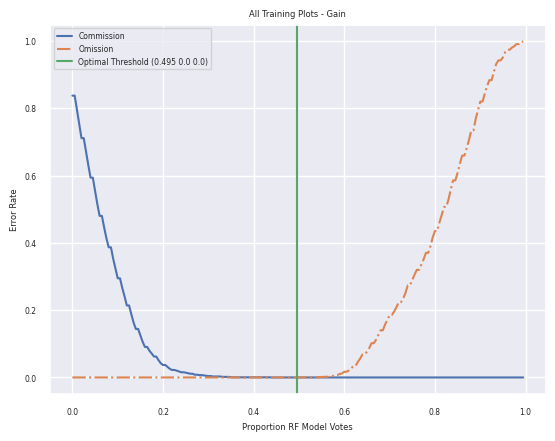

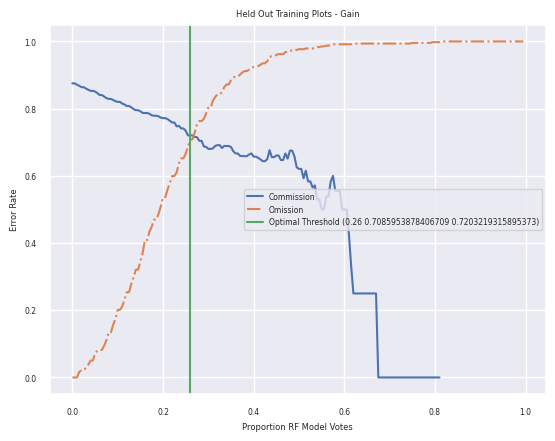

{'Stable': 0.66, 'Slow Loss': 0.055, 'Fast Loss': 0.16, 'Gain': 0.26}
Done


In [92]:
# Next we'll compute the proportion of votes that balances omission and commission

# Specify individual class names and codes for change
change_class_codes = {'Stable':1,'Slow Loss':2,'Fast Loss':3,'Gain':4}

# Make a function that will take a list of binary reference and probablity (0-1 float) 
# predicted values and find the optimal threshold to balance omission and commission
def getBalancedThreshold(y_ref_binary,y_pred_probs,title='Omission-Commission Error',thresholds = list(np.arange(0,1,0.005))):
    
    omission = []
    commission = []
    
    # Iterate across each threshold and compute the omission and commision error rates
    for threshold in thresholds:
        
        y_pred_binary = np.where(y_pred_probs>threshold, 1, 0)
        fp = (y_pred_binary == 1) & (y_ref_binary == 0) 
        pred_positive = y_pred_binary == 1
        ref_positive = y_ref_binary == 1
        ref_negative = y_ref_binary == 0
        fn = (y_pred_binary == 0) & (y_ref_binary == 1) 
        tp = (y_pred_binary == 1) & (y_ref_binary == 1) 
        commission.append(sum(fp)/sum(pred_positive))
        omission.append(sum(fn)/sum(ref_positive))
    
    # Find the threshold that corresponds to the smallest difference between omission and commission
    diff = np.abs(np.array(omission)-np.array(commission))
    diff = np.stack((thresholds,diff,omission,commission),1)
    diff = diff[diff[:, 1].argsort()]
    crossover = diff[0]
    optimal_thresh = crossover[0]
    
    # Plot the curves
    plt.plot(thresholds, commission,label='Commission')
    plt.plot(thresholds,omission, '-.',label='Omission')
    plt.axvline(x = optimal_thresh, color = 'g', label = f'Optimal Threshold ({optimal_thresh} {crossover[2]} {crossover[3]})')
    plt.xlabel("Proportion RF Model Votes")
    plt.ylabel("Error Rate")
    plt.title(title)
    plt.legend()
    plt.show()
    
    
    return optimal_thresh

# Iterate across each class and find the optimal threshold
out_threshold_dict = {}
for change_class,change_code in list(change_class_codes.items()):
    print(change_class,change_code)
    y_pred_prob_rf_all =rf_all_probs[:,change_code-1]
    y_pred_prob_rf_holdout =rf_holdout_probs[:,change_code-1]
    
    y_ref_binary = np.where(y==change_code, 1, 0)
    y_test_binary = np.where(y_test==change_code,1,0)
    rf_all_thresh = getBalancedThreshold(y_ref_binary,y_pred_prob_rf_all,f'All Training Plots - {change_class}')
    rf_holdout_thresh = getBalancedThreshold(y_test_binary,y_pred_prob_rf_holdout,f'Held Out Training Plots - {change_class}')
    out_threshold_dict[change_class] = rf_holdout_thresh

print(out_threshold_dict)

# Save table for use in notebook 5.2
model_options_csv_filename = os.path.join(local_model_data_folder,'LCMS_change_thresholds.csv')
o = open(model_options_csv_filename,'w')
o.write(json.dumps(out_threshold_dict))
o.close()

o = open(model_options_csv_filename,'r')
threshs = json.load(o)
o.close()


print('Done')

* Notice if we don't use a holdout, the threshold always hovers near 0.5
* This is wrong since the model contains the data being used to derive the threshold
* Also notice the slow loss threshold is near zero with an error rate near 1. Recall we have very few slow loss samples. This indicates our models are unlikely to be able to predict slow loss at all.
* Note that both fast loss and gain have thresholds far below 0.5 and error rates around 0.7 or so. This indicates our models are rarely confident of classifying these classes, and the omission and commission error rates are high. Simply put, modeling change is extremely difficult.